# Projet ouverture

| Authors |
|:-|
|SAGDULLIN Damir|
|LAIOLO Léo|
|TABBAH Nicola|

**Introduction**

This project aim to recognize attacks on connected vehicles using Deep Learning (DL).

In [1]:
#@title Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils import resample

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, Dropout
%load_ext tensorboard

import datetime

import os
import re
from PIL import Image
import imghdr

import shutil
import random

from collections import Counter

In [2]:
# @title Execution mode

# @markdown This jupyter notebook can either be run on Google colab or on a local machine.

# @markdown Please select your computation mode:
computation_mode = "Google Colab" # @param ["Google Colab", "Local"]

# @markdown If you chose `Local`computation mode, please specify the path to the dataset folder.
path = "./" # @param {type:"string"}

if computation_mode == "Google Colab":
  print("Connecting to Google Drive...")
  from google.colab import drive

  # Drive connection
  drive.mount('/content/drive')

  # Path when the files are in a shared drive
  path = '"/content/drive/Shareddrives/ING3 Ouverture/Projeсt/"'

  # Move in directories
  %cd $path

  path = "./"

else:
  print("Executing with local data")

Connecting to Google Drive...
Mounted at /content/drive
/content/drive/Shareddrives/ING3 Ouverture/Projeсt


## Dataset

Our dataset is quite big. Generating it takes a lot of time. This is why we saved it in a CSV file.

To discribe the treatments applied to the original dataset, we extract only a piece of the original dataset and pre-treat it. In this section, you can follow data transformation on a little portion of the dataset. At the end, we download the full pretreated dataset to train our models.

Our dataset is a part of the Vehicular Reference Misbehavior (VeReMi), built specifically for testing V2X security. We uses the received message historics from 2260 connected vehicles. Some of them send malicious messages of 19 different types.

Connected vehicles exchange lots of messages, to localize themselves or get traffic state, with other vehicles, roadside elements and infrastructures. In this study, we only work on exchanges between vehicles. This kind of message is declared with a `type:3`. So we first select all the `type:3` messages from our vehicles.


### Import data

Our dataset is made of two parts:
1. The labels
2. The messages per vehicles

Labels are a list of message sender vehicle labelised as `0` for benign and `X` for malicious, where `X` corresponds to the index of the attack. We import this list of vehicles from a CSV file.

The second part of the dataset is composed of 2260 vehicles' message historics. We import them and keep only the `type:3` messages, exchanged by vehicles. Here is an example of a message content:
```python
{
  "type":3,
  "rcvTime":50427.66028717679,
  "sendTime":50427.66028717679,
  "sender":57,
  "senderPseudo":10575,
  "messageID":67985,
  "pos":[983.2263964536893,910.8786100947851,0.0],
  "pos_noise":[3.6170773833523657,3.9726270832479986,0.0],
  "spd":[-8.160545717352005,-5.838995406773277,0.0],
  "spd_noise":[-0.013202827672876944,-0.00944703121125735,0.0],
  "acl":[-0.1056377948217638,-0.07553041612577578,0.0],
  "acl_noise":[0.001235094686840946,0.0021069253674089584,0.0],
  "hed":[-0.8479991671178503,-0.5299975590202584,0.0],
  "hed_noise":[24.07432760428006,19.08668548660413,0.0]
}
```

In [3]:
# @title
def jsons_to_df(jsons: list, path="", offset=0, limit=-1, verbose=0):
  # type of the messages to keep
  type_msg = 3

  # columns to keep
  cols = [
      "rcvTime",
      "sendTime",
      "sender",
      "senderPseudo",
      "messageID",
      "pos",
      "pos_noise",
      "spd",
      "spd_noise",
      "acl",
      "acl_noise",
      "hed",
      "hed_noise"
  ]

  dt_jsons = pd.DataFrame(
      columns=[
          "file",
          "receiver",
          "omnet_module_id",
          "attacker_type",
          "rcvTime",
          "sendTime",
          "sender",
          "senderPseudo",
          "messageID",
          "pos",
          "pos_noise",
          "spd",
          "spd_noise",
          "acl",
          "acl_noise",
          "hed",
          "hed_noise"
      ]
  )

  if verbose > 0:
    print("Importing Jsons...")

  if limit < 0:
    limit = len(jsons)

  for i,j in enumerate(jsons):
    if verbose > 0:
      print(f"\tFile {i+1}/{limit+offset}: {j}")

    if j == "traceGroundTruthJSON-18.json" or offset > i:
      if verbose > 0:
        print("Skipping :",j)
    else:
      json_name = j.split('.')[0]
      json_info = json_name.split('-')
      receiver = json_info[1]
      module_id = json_info[2]
      attack = json_info[3]

      temp_dt = pd.read_json(path+j, lines=True)

      temp_dt = temp_dt.query("type == "+str(type_msg))

      temp_dt = temp_dt[cols]

      nb_rows = len(temp_dt)

      temp_dt.insert(0, "attacker_type", [attack]*nb_rows, True)
      temp_dt.insert(0, "omnet_module_id", [module_id]*nb_rows, True)
      temp_dt.insert(0, "receiver", [receiver]*nb_rows, True)
      temp_dt.insert(0, "file", [j]*nb_rows, True)

      if verbose > 1:
        print("\t | - > Concatenation...")

      dt_jsons = pd.concat([dt_jsons, temp_dt])

      if verbose > 1:
        print("\t \ - > Done")

    if i+1 >= limit+offset:
      if verbose > 0:
        print("STOP IMPORTATION: Json limit reached. ")
      break

  return dt_jsons

In [4]:
# @title Choose Dataset

# @markdown To see an example of pretreatments, you can select a directory containing json message historics and the number of files to load.

# BSM messages data
dataset_directory = "VeReMi_64800_68400_2022-9-11_12_51_1/" # @param ["VeReMi_64800_68400_2022-9-11_12_51_1/"]
number_vehicles = 5 # @param {type:"integer"}

# number_vehicles = -1 # Generate the full dataset

msgs_df = jsons_to_df(os.listdir(path+"MixAll_0024/"+dataset_directory), path+"MixAll_0024/"+dataset_directory, limit=number_vehicles, verbose=2)
msgs_df.head()

Importing Jsons...
	File 1/5: traceJSON-110589-110587-A0-66720-18.json
	 | - > Concatenation...
	 \ - > Done
	File 2/5: traceJSON-110553-110551-A16-66714-18.json
	 | - > Concatenation...
	 \ - > Done
	File 3/5: traceJSON-110661-110659-A0-66733-18.json
	 | - > Concatenation...
	 \ - > Done
	File 4/5: traceJSON-110715-110713-A5-66742-18.json
	 | - > Concatenation...
	 \ - > Done
	File 5/5: traceJSON-110667-110665-A0-66733-18.json
	 | - > Concatenation...
	 \ - > Done
STOP IMPORTATION: Json limit reached. 


,file,receiver,omnet_module_id,attacker_type,rcvTime,sendTime,sender,senderPseudo,messageID,pos,pos_noise,spd,spd_noise,acl,acl_noise,hed,hed_noise
1,traceJSON-110589-110587-A0-66720-18.json,110589,110587,A0,66720.166515,66720.166515,110553.0,401105536.0,327420924.0,"[218.8030214924371, 351.56246751726826, 0.0]","[4.499399532333812, 4.245417381907802, 0.0]","[0.6511350682436341, -4.445593369544584, 0.0]","[0.001246906228255, 0.008402796651501001, 0.0]","[0.660587944831995, -4.451200553520713, 0.0]","[0.001246906228255, 0.008402796651501001, 0.0]","[-0.14899546530663701, 0.9888378791885241, 0.0]","[0.307690062774776, 0.263056800600499, 0.0]"
2,traceJSON-110589-110587-A0-66720-18.json,110589,110587,A0,66720.240539,66720.240539,110511.0,101105116.0,327422982.0,"[255.32227783802597, 216.49732424020434, 0.0]","[4.302241902324623, 4.454706063657825, 0.0]","[1.9399182723309272, -13.161627172267254, 0.0]","[0.0018694374782200001, -0.012684163736594001,...","[0.31437199621933604, -2.132997469398125, 0.0]","[0.000324456073235, 0.0022791265448470002, 0.0]","[0.137584770829558, -0.9904899953234141, 0.0]","[4.425094409085542, 20.03430708128379, 0.0]"
3,traceJSON-110589-110587-A0-66720-18.json,110589,110587,A0,66720.333184,66720.333184,110553.0,501105536.0,327423894.0,"[222.642135823126, 351.7438384364566, 0.0]","[4.499399532333812, 4.245417381907802, 0.0]","[0.662028158979852, -4.436863364305085, 0.0]","[0.001344301592055, 0.008500192015300001, 0.0]","[0.660587944831995, -4.451200553520713, 0.0]","[0.001246906228255, 0.008402796651501001, 0.0]","[-0.150441886784471, 0.988618854109473, 0.0]","[0.32114997604058104, 0.276516713866304, 0.0]"
4,traceJSON-110589-110587-A0-66720-18.json,110589,110587,A0,66720.377716,66720.377716,110529.0,101105296.0,327424449.0,"[260.75646181061524, 121.96232309401566, 0.0]","[4.304836150974627, 4.321821319536195, 0.0]","[-2.030294823724096, 12.400364114803214, 0.0]","[0.001086432694534, -0.006635312425496, 0.0]","[-0.11821718884358301, 0.7221433693151821, 0.0]","[9.781234953000001e-06, 3.2093208017e-05, 0.0]","[-0.128019937218306, 0.9917715945088471, 0.0]","[10.501755058696004, 2.4805405441814212, 0.0]"
5,traceJSON-110589-110587-A0-66720-18.json,110589,110587,A0,66720.388333,66720.388333,110433.0,101104336.0,327424941.0,"[220.48138282019374, 387.7310061633867, 0.0]","[4.742514172515643, 4.543715280051515, 0.0]","[6.300901814721588, 5.388809428171275, 0.0]","[-0.0, 0.0, 0.0]","[6.3117330265e-05, 6.3117330265e-05, 0.0]","[0.0, 0.0, 0.0]","[-0.131664775196007, 0.991294298870211, 0.0]","[4.110231426167397, 4.110231426167397, 0.0]"


In [5]:
# @title
msgs_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5880 entries, 1 to 1183
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   file             5880 non-null   object 
 1   receiver         5880 non-null   object 
 2   omnet_module_id  5880 non-null   object 
 3   attacker_type    5880 non-null   object 
 4   rcvTime          5880 non-null   float64
 5   sendTime         5880 non-null   float64
 6   sender           5880 non-null   float64
 7   senderPseudo     5880 non-null   float64
 8   messageID        5880 non-null   float64
 9   pos              5880 non-null   object 
 10  pos_noise        5880 non-null   object 
 11  spd              5880 non-null   object 
 12  spd_noise        5880 non-null   object 
 13  acl              5880 non-null   object 
 14  acl_noise        5880 non-null   object 
 15  hed              5880 non-null   object 
 16  hed_noise        5880 non-null   object 
dtypes: float64(5), obje

In [6]:
# @title Generate sender label

# @markdown The labels need to be generated from the json files. To do so, we look for the receiver vehicles categorized as malicious, we extract their type of attack then we save those data into a special dataset.

sender_label_df = pd.DataFrame()
sender_label_df = msgs_df[["receiver","attacker_type"]].drop_duplicates()
sender_label_df = sender_label_df.rename(columns={"receiver": "sender", "attacker_type": "label"})
sender_label_df["label"] = sender_label_df["label"].apply(lambda x: int(x[1:]))
sender_label_df["sender"] = sender_label_df["sender"].apply(lambda x: int(x))
sender_label_df = sender_label_df.sort_values("sender", axis=0)
sender_label_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 1 to 1
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sender  5 non-null      int64
 1   label   5 non-null      int64
dtypes: int64(2)
memory usage: 120.0 bytes


### Merge BSM messages and senders labels data

Once our data imported, we centralize all the data to easily pretreat them. To do so, we merge the 2 parts of our dataset.

Because we are working on a sample of the dataset, some information might be missing. To ensure that the rest of the treatments will run properly, we delete those incomplete rows.

In [7]:
# @title
# Labeled BSM messages data
labeled_msgs_df = pd.merge(msgs_df, sender_label_df, on='sender', how='right')
labeled_msgs_df = labeled_msgs_df.dropna()
labeled_msgs_df.head()

,file,receiver,omnet_module_id,attacker_type,rcvTime,sendTime,sender,senderPseudo,messageID,pos,pos_noise,spd,spd_noise,acl,acl_noise,hed,hed_noise,label
0,traceJSON-110589-110587-A0-66720-18.json,110589,110587,A0,66720.166515,66720.166515,110553.0,401105536.0,327420924.0,"[218.8030214924371, 351.56246751726826, 0.0]","[4.499399532333812, 4.245417381907802, 0.0]","[0.6511350682436341, -4.445593369544584, 0.0]","[0.001246906228255, 0.008402796651501001, 0.0]","[0.660587944831995, -4.451200553520713, 0.0]","[0.001246906228255, 0.008402796651501001, 0.0]","[-0.14899546530663701, 0.9888378791885241, 0.0]","[0.307690062774776, 0.263056800600499, 0.0]",16
1,traceJSON-110589-110587-A0-66720-18.json,110589,110587,A0,66720.333184,66720.333184,110553.0,501105536.0,327423894.0,"[222.642135823126, 351.7438384364566, 0.0]","[4.499399532333812, 4.245417381907802, 0.0]","[0.662028158979852, -4.436863364305085, 0.0]","[0.001344301592055, 0.008500192015300001, 0.0]","[0.660587944831995, -4.451200553520713, 0.0]","[0.001246906228255, 0.008402796651501001, 0.0]","[-0.150441886784471, 0.988618854109473, 0.0]","[0.32114997604058104, 0.276516713866304, 0.0]",16
2,traceJSON-110589-110587-A0-66720-18.json,110589,110587,A0,66720.499859,66720.499859,110553.0,601105536.0,327426672.0,"[221.0896997523466, 334.1941484930747, 0.0]","[4.8053144027751, 4.55133225234909, 0.0]","[0.6712244632994441, -4.450532855703883, 0.0]","[0.001246906228255, 0.008402796651501001, 0.0]","[0.660587944831995, -4.451200553520713, 0.0]","[0.001246906228255, 0.008402796651501001, 0.0]","[-0.14438321755482902, 0.989521847403337, 0.0]","[0.307690062774776, 0.263056800600499, 0.0]",16
3,traceJSON-110589-110587-A0-66720-18.json,110589,110587,A0,66720.666523,66720.666523,110553.0,101105536.0,327428696.0,"[257.3927212802009, 202.6131068386307, 0.0]","[4.346609776374659, 4.105663805102685, 0.0]","[2.032919947099403, -14.031269641545789, 0.0]","[0.00195907587896, -0.013522240915404, 0.0]","[0.10245583323396801, -0.707171904382068, 0.0]","[8.963840074e-05, 0.00083807717881, 0.0]","[0.135154542312274, -0.990824530223368, 0.0]","[4.38412597436519, 21.854552300772795, 0.0]",16
4,traceJSON-110589-110587-A0-66720-18.json,110589,110587,A0,66720.833180,66720.833180,110553.0,201105536.0,327430981.0,"[215.8751366258579, 369.5432792350747, 0.0]","[4.897442110141453, 4.629825953190208, 0.0]","[5.3837447637000004e-05, 5.2964745746000004e-0...","[0.000396035007828, 0.002589969004586, 0.0]","[5.4428105469000004e-05, 5.4428105469000004e-0...","[0.00038229064492800003, 0.002576224641686, 0.0]","[-0.15243778316553702, 0.9883130689531411, 0.0]","[0.301521613661252, 0.301521613661252, 0.0]",16


### Split list features

We see in the tables displayed in the above section that some message data are lists of coordinates, like the position `pos`. Our model needs flatten data, not nested lists. Therefore, we split those coordinates into columns `x`, `y` and `z`, spliting `pos` into `pos_x`, `pos_y` and `pos_z`.

In [8]:
# @title
def split_list(row, col_name):
    return pd.Series(row[col_name], index=[f'{col_name}_x', f'{col_name}_y', f'{col_name}_z'])

for col in ['pos', 'pos_noise', 'spd', 'spd_noise', 'acl', 'acl_noise', 'hed', 'hed_noise']:
    if col in labeled_msgs_df.columns:
        labeled_msgs_df[[f'{col}_x', f'{col}_y', f'{col}_z']] = labeled_msgs_df.apply(split_list, col_name=col, axis=1)
        labeled_msgs_df = labeled_msgs_df.drop(columns=[col])

labeled_msgs_df.head()

,file,receiver,omnet_module_id,attacker_type,rcvTime,sendTime,sender,senderPseudo,messageID,label,...,acl_z,acl_noise_x,acl_noise_y,acl_noise_z,hed_x,hed_y,hed_z,hed_noise_x,hed_noise_y,hed_noise_z
0,traceJSON-110589-110587-A0-66720-18.json,110589,110587,A0,66720.166515,66720.166515,110553.0,401105536.0,327420924.0,16,...,0.0,0.001247,0.008403,0.0,-0.148995,0.988838,0.0,0.307690,0.263057,0.0
1,traceJSON-110589-110587-A0-66720-18.json,110589,110587,A0,66720.333184,66720.333184,110553.0,501105536.0,327423894.0,16,...,0.0,0.001247,0.008403,0.0,-0.150442,0.988619,0.0,0.321150,0.276517,0.0
2,traceJSON-110589-110587-A0-66720-18.json,110589,110587,A0,66720.499859,66720.499859,110553.0,601105536.0,327426672.0,16,...,0.0,0.001247,0.008403,0.0,-0.144383,0.989522,0.0,0.307690,0.263057,0.0
3,traceJSON-110589-110587-A0-66720-18.json,110589,110587,A0,66720.666523,66720.666523,110553.0,101105536.0,327428696.0,16,...,0.0,0.000090,0.000838,0.0,0.135155,-0.990825,0.0,4.384126,21.854552,0.0
4,traceJSON-110589-110587-A0-66720-18.json,110589,110587,A0,66720.833180,66720.833180,110553.0,201105536.0,327430981.0,16,...,0.0,0.000382,0.002576,0.0,-0.152438,0.988313,0.0,0.301522,0.301522,0.0


In [9]:
# @title
labeled_msgs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   file             257 non-null    object 
 1   receiver         257 non-null    object 
 2   omnet_module_id  257 non-null    object 
 3   attacker_type    257 non-null    object 
 4   rcvTime          257 non-null    float64
 5   sendTime         257 non-null    float64
 6   sender           257 non-null    float64
 7   senderPseudo     257 non-null    float64
 8   messageID        257 non-null    float64
 9   label            257 non-null    int64  
 10  pos_x            257 non-null    float64
 11  pos_y            257 non-null    float64
 12  pos_z            257 non-null    float64
 13  pos_noise_x      257 non-null    float64
 14  pos_noise_y      257 non-null    float64
 15  pos_noise_z      257 non-null    float64
 16  spd_x            257 non-null    float64
 17  spd_y           

### Drop irrelevant cols

Looking at the message data, we see that some information are irrelevant. Indeed, we are about to split our dataset on receiver vehicles. They can be identified by each one of the following data:
- `sender`, the message sender is the vehicle;
- `file`, each historic file belongs to one and only vehicle;
- `omnet_module_id`, the vehicles' id on the network didn't change during the message recording.

Once our dataset split, those columns would be filled with the same value, making it irrelevant for the model.

There are also information that couldn't be interpreted by the model and wouldn't help it to understand the messages. Those are listed below:
- `senderPseudo`, the pseudo of the vehicles are integers aiming for sender differenciation;
- `messageID`, id serve to distinguish messages that could contain the same information.

Those information are generated by the sender's communication protocols. They can be faked but are to hard to recognize, even for human. Keeping those data would brings more difficulties to understand the message than dropping it.

Finaly, the `attacker_type` indicates if the receiver vehicle is malicious (`A13`) or not (`A0`). It is a data related to the receiver vehicle so it is useless to understand received message in our case.

In [10]:
# @title
for col in ['attacker_type', 'senderPseudo', 'omnet_module_id', 'file', 'messageID', 'sender']:
    if col in labeled_msgs_df.columns:
        labeled_msgs_df = labeled_msgs_df.drop(columns=[col])
labeled_msgs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   receiver     257 non-null    object 
 1   rcvTime      257 non-null    float64
 2   sendTime     257 non-null    float64
 3   label        257 non-null    int64  
 4   pos_x        257 non-null    float64
 5   pos_y        257 non-null    float64
 6   pos_z        257 non-null    float64
 7   pos_noise_x  257 non-null    float64
 8   pos_noise_y  257 non-null    float64
 9   pos_noise_z  257 non-null    float64
 10  spd_x        257 non-null    float64
 11  spd_y        257 non-null    float64
 12  spd_z        257 non-null    float64
 13  spd_noise_x  257 non-null    float64
 14  spd_noise_y  257 non-null    float64
 15  spd_noise_z  257 non-null    float64
 16  acl_x        257 non-null    float64
 17  acl_y        257 non-null    float64
 18  acl_z        257 non-null    float64
 19  acl_nois

### Scale data

To improve our model efficiency, we scale the data, excepted the labels.

In [13]:
# @title
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

cols_to_scale = labeled_msgs_df.columns.drop(['receiver', 'label'])

labeled_msgs_df[cols_to_scale] = scaler.fit_transform(labeled_msgs_df[cols_to_scale])

labeled_msgs_df.describe()

,rcvTime,sendTime,label,pos_x,pos_y,pos_z,pos_noise_x,pos_noise_y,pos_noise_z,spd_x,...,acl_z,acl_noise_x,acl_noise_y,acl_noise_z,hed_x,hed_y,hed_z,hed_noise_x,hed_noise_y,hed_noise_z
count,257.000000,257.000000,257.000000,257.000000,257.000000,257.0,257.000000,257.000000,257.0,257.000000,...,257.0,257.000000,257.000000,257.0,257.000000,257.000000,257.0,257.000000,257.000000,257.0
mean,0.416162,0.416162,5.579767,0.340015,0.483747,0.0,0.370359,0.396839,0.0,0.585102,...,0.0,0.056489,0.076470,0.0,0.593472,0.743008,0.0,0.183204,0.221761,0.0
std,0.362934,0.362934,7.382574,0.328630,0.346629,0.0,0.261577,0.267006,0.0,0.248060,...,0.0,0.141830,0.128078,0.0,0.280109,0.326136,0.0,0.208273,0.248673,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
25%,0.070633,0.070633,0.000000,0.059629,0.138644,0.0,0.159632,0.162508,0.0,0.428362,...,0.0,0.002348,0.001805,0.0,0.418179,0.613950,0.0,0.042685,0.084456,0.0
50%,0.250258,0.250258,0.000000,0.085371,0.375982,0.0,0.261255,0.295461,0.0,0.490051,...,0.0,0.014904,0.016650,0.0,0.447342,0.872596,0.0,0.103928,0.140766,0.0
75%,0.766824,0.766824,16.000000,0.650239,0.822959,0.0,0.630547,0.671605,0.0,0.787210,...,0.0,0.033325,0.122268,0.0,0.890471,0.994414,0.0,0.240366,0.219754,0.0
max,1.000000,1.000000,16.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,...,0.0,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000,0.0


### Load full dataset

In the previous section, we saw all the treatments applied to a sample of the original dataset. Now, we load the complete pretreated dataset. This last one will be used to train the proposed model.

In [31]:
# @title
def load_split_csv(path, name):
  df = pd.DataFrame()
  for file in os.listdir(path):
    if file.startswith(name+"_part_"):
      df = pd.concat([
          df,
          pd.read_csv(path+file)
      ])
  return df.drop(columns=df.columns[0])

# full_df2 = load_split_csv(path+"Dataset/", "pretreated_dataset")
full_df2 = pd.read_csv(path+"Dataset/pretreated_dataset_full.csv")

labeled_msgs_df = full_df2.drop(columns="Unnamed: 0")
labeled_msgs_df.describe()

,receiver,rcvTime,sendTime,label,pos_x,pos_y,pos_z,pos_noise_x,pos_noise_y,pos_noise_z,...,acl_z,acl_noise_x,acl_noise_y,acl_noise_z,hed_x,hed_y,hed_z,hed_noise_x,hed_noise_y,hed_noise_z
count,2.299626e+06,2.299626e+06,2.299626e+06,2.299626e+06,2.299626e+06,2.299626e+06,2299626.0,2.299626e+06,2.299626e+06,2299626.0,...,2299626.0,2.299626e+06,2.299626e+06,2299626.0,2.299626e+06,2.299626e+06,2299626.0,2.299626e+06,2.299626e+06,2299626.0
mean,1.097735e+05,4.396304e-01,4.396304e-01,3.441680e+00,3.409545e-01,4.195378e-01,0.0,6.824785e-01,6.906037e-01,0.0,...,0.0,9.063236e-03,1.163725e-02,0.0,5.100590e-01,4.805868e-01,0.0,1.227679e-01,1.504514e-01,0.0
std,3.884251e+03,3.143329e-01,3.143329e-01,5.375860e+00,2.619478e-01,2.173346e-01,0.0,1.181823e-01,1.197225e-01,0.0,...,0.0,2.954409e-02,3.078105e-02,0.0,3.188714e-01,3.733148e-01,0.0,1.283282e-01,1.643604e-01,0.0
min,1.031670e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,...,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0
25%,1.064790e+05,1.581104e-01,1.581104e-01,0.000000e+00,1.344144e-01,2.357457e-01,0.0,6.018823e-01,6.082203e-01,0.0,...,0.0,5.448632e-05,6.423115e-05,0.0,2.905189e-01,3.651740e-02,0.0,3.773851e-02,4.129659e-02,0.0
50%,1.094850e+05,3.057054e-01,3.057054e-01,0.000000e+00,1.841866e-01,4.215914e-01,0.0,6.867209e-01,6.942325e-01,0.0,...,0.0,7.390198e-04,7.854711e-04,0.0,5.110237e-01,5.088126e-01,0.0,8.773847e-02,9.356415e-02,0.0
75%,1.130610e+05,7.499819e-01,7.499819e-01,6.000000e+00,5.767359e-01,6.009121e-01,0.0,7.705348e-01,7.807943e-01,0.0,...,0.0,5.049515e-03,8.499335e-03,0.0,7.807548e-01,8.425415e-01,0.0,1.570364e-01,1.868190e-01,0.0
max,1.167210e+05,1.000000e+00,1.000000e+00,1.900000e+01,1.000000e+00,1.000000e+00,0.0,1.000000e+00,1.000000e+00,0.0,...,0.0,1.000000e+00,1.000000e+00,0.0,1.000000e+00,1.000000e+00,0.0,1.000000e+00,1.000000e+00,0.0


In [32]:
# @title
labeled_msgs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299626 entries, 0 to 2299625
Data columns (total 28 columns):
 #   Column       Dtype  
---  ------       -----  
 0   receiver     int64  
 1   rcvTime      float64
 2   sendTime     float64
 3   label        int64  
 4   pos_x        float64
 5   pos_y        float64
 6   pos_z        float64
 7   pos_noise_x  float64
 8   pos_noise_y  float64
 9   pos_noise_z  float64
 10  spd_x        float64
 11  spd_y        float64
 12  spd_z        float64
 13  spd_noise_x  float64
 14  spd_noise_y  float64
 15  spd_noise_z  float64
 16  acl_x        float64
 17  acl_y        float64
 18  acl_z        float64
 19  acl_noise_x  float64
 20  acl_noise_y  float64
 21  acl_noise_z  float64
 22  hed_x        float64
 23  hed_y        float64
 24  hed_z        float64
 25  hed_noise_x  float64
 26  hed_noise_y  float64
 27  hed_noise_z  float64
dtypes: float64(26), int64(2)
memory usage: 491.3 MB


In [28]:
# @title
sender_label_df = pd.read_csv(path+"Dataset/all_labels.csv")
attack_classes = sender_label_df["label"].unique()
print("Attack classes :", attack_classes)

Attack classes : [ 0 17 15  6  8  9 19 11 14 16  7  1 10  3 12 18  2  5 13  4]


## DNN

In this project, we choose to implement a classic Deep Neural Network (DNN). Indeed, we observed in the TP4 that this model was more efficient than Recurrent Neural Network. However, we didn't use Federated learning to compare this method with centralized training.

Labels distribution


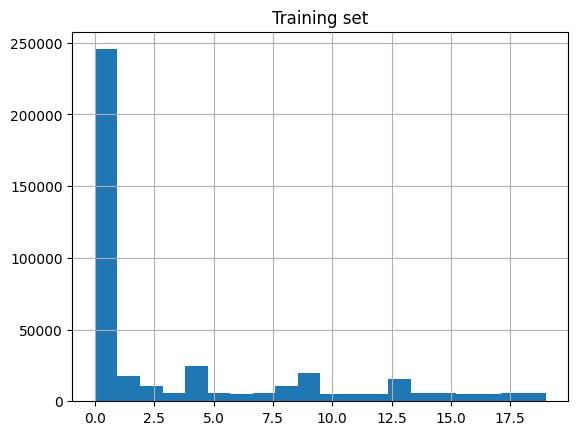

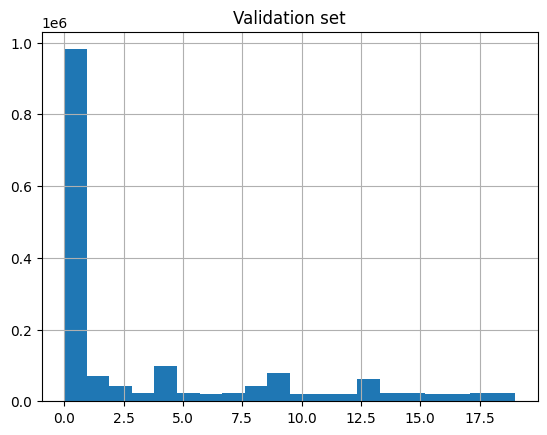

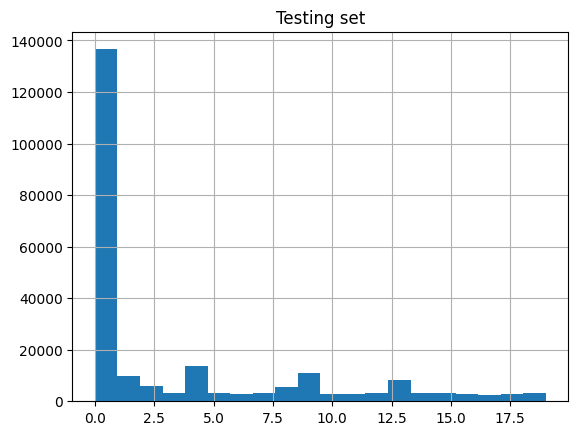

In [19]:

# @title Generate train, validation and test

# @markdown Though we pretreated the dataset, it still needs to be prepared for our model.
# @markdown We choose to train our Deep Learning model using the *Train, Validate and Test* method. Therefore, we need to generate subsets.
# @markdown
# @markdown The datasets follow the distribution:
# @markdown *   72% for training
# @markdown *   18% for validation
# @markdown *   10% for test

dnn_train_val_df, dnn_test_df = train_test_split(labeled_msgs_df.drop(columns="receiver"), test_size=0.1, random_state=42)
dnn_train_df, dnn_val_df = train_test_split(dnn_train_val_df, test_size=0.8, random_state=42)
del dnn_train_val_df

print("Labels distribution")
dnn_train_df["label"].hist(bins=len(attack_classes))
plt.title("Training set")
plt.show()
dnn_val_df["label"].hist(bins=len(attack_classes))
plt.title("Validation set")
plt.show()
dnn_test_df["label"].hist(bins=len(attack_classes))
plt.title("Testing set")
plt.show()


Class=0, n=245370 (5.000%)
Class=13, n=245370 (5.000%)
Class=9, n=245370 (5.000%)
Class=4, n=245370 (5.000%)
Class=18, n=245370 (5.000%)
Class=6, n=245370 (5.000%)
Class=15, n=245370 (5.000%)
Class=3, n=245370 (5.000%)
Class=14, n=245370 (5.000%)
Class=1, n=245370 (5.000%)
Class=7, n=245370 (5.000%)
Class=5, n=245370 (5.000%)
Class=2, n=245370 (5.000%)
Class=8, n=245370 (5.000%)
Class=17, n=245370 (5.000%)
Class=19, n=245370 (5.000%)
Class=16, n=245370 (5.000%)
Class=11, n=245370 (5.000%)
Class=10, n=245370 (5.000%)
Class=12, n=245370 (5.000%)


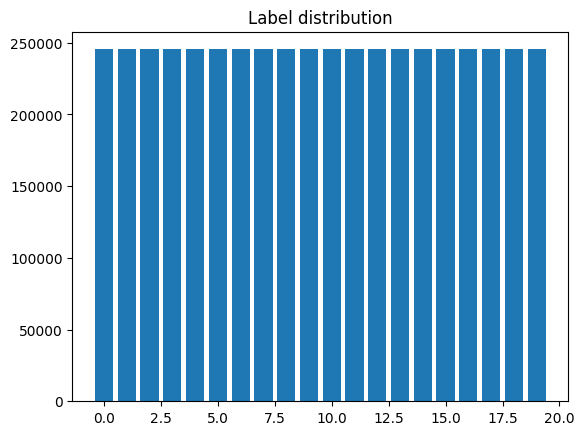

In [29]:
# @title Balancing dataset

# @markdown Our datasets are almost ready. We now want to ensure that benign and malicious messages are balanced.
# @markdown
# @markdown As we can see in the histograms above, none of the datasets are balanced. There is more normal messages than attacks. We need them to be more equitably distributed to optimize our model's performance.

# @markdown One way to balance a dataset is to do *Oversampling*. This method consist to duplicates data from the minority class until all the classes have the same amount of elements.

# @markdown Here, we used *Synthetic Minority Oversampling Technique* (SMOTE), which consists to generate new data with couples of close data. In it based on the K-NN technique.


from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder

X_balanced_train, y_balanced_train = dnn_train_df.drop(columns="label"), dnn_train_df["label"]
# label encode the target variable
y_balanced_train = LabelEncoder().fit_transform(y_balanced_train)
# transform the dataset
oversample = SMOTE()
X_balanced_train, y_balanced_train = oversample.fit_resample(X_balanced_train, y_balanced_train)
# summarize distribution
counter = Counter(y_balanced_train)
for k,v in counter.items():
	per = v / len(y_balanced_train) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.title("Label distribution")
plt.show()

In [21]:
# @title Generating model

# @markdown We implemented Deep Neural Network (`DNN`). A DNN is a Neural Network that has more than one hidden layer. Here, it has the following architecture:
# @markdown
# @markdown | Layer | Number of neurones | Activation |
# @markdown |-|-|-|
# @markdown | Input | $N$ | ReLU |
# @markdown | Feed forward 1 | 128 | ReLU |
# @markdown | Feed forward 2 | 64 | ReLU |
# @markdown | Feed forward 3 | 32 | ReLU |
# @markdown | Output | $m$ | Softmax |
# @markdown
# @markdown where $N$ is the number of features fed to the network and $m$ is the number of classes. In this project, $m$ is equal to $20$ .

# @markdown This is the same architecture used in for Federated Learning, excepted the last layer.

dnn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_balanced_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(attack_classes), activation='softmax')
])

dnn_model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'],
            run_eagerly=True)

In [22]:
# @title Load pretrained weights

# @markdown We trained the same model on different numbers of epochs. You can choose them by writing a file name from the folder `Weights/`. This way, you can see the model's evolution.

# @markdown Input the file name contening saved weights:

load_weight_file = "dnn_50epoch.keras" # @param {type:"string"}

dnn_model.load_weights(path+"Weights/"+load_weight_file)

In [23]:
# @title Training

# @markdown To train our model, we define two hyper parameters:
# @markdown  - `epochs` , the number of training epochs for the local models
# @markdown  - `pow2_batch_size` , power applied to 2 to define the number of messages used for in a batch
# @markdown
# @markdown
# @markdown We also used an early stopping method so the local models doesn't do overfitting.

# @markdown Be aware that because of the huge dataset, **models take a long time to train**. We advise you to save it in a file after each training.


# @markdown Set training parameters:

epochs=1 # @param {type:"slider", min:"1", max:"50", step:"1"}
pow2_batch_size = 10 # @param {type:"slider", min:"0", max:"10", step:"1"}

print(f"Batch size set to {2**pow2_batch_size} .")

# Define the early stopping callback
# to stop training if val_loss starts to grow (model overfits) or stagnates
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.01,
    restore_best_weights=True
)


dnn_model.fit(
    x=tf.convert_to_tensor(X_balanced_train, dtype=tf.float32),
    y=tf.convert_to_tensor(y_balanced_train, dtype=tf.int32),
    batch_size=2**pow2_batch_size,
    epochs=epochs,
    validation_data=(dnn_val_df.drop(columns='label'), dnn_val_df['label']),
    callbacks=[early_stopping],
    verbose=2,
)

Batch size set to 1024 .


4793/4793 - 194s - loss: 0.7460 - accuracy: 0.7558 - val_loss: 1.5598 - val_accuracy: 0.3963 - 194s/epoch - 40ms/step


In [24]:
# @title Saving

# @markdown Input the file name where the model's weights will be saved:

save_weight_file = "" # @param {type:"string"}

if save_weight_file != "":
  dnn_model.save_weights(path+"Weights/"+save_weight_file)

7187/7187 [==============================] - 35s 5ms/step
              precision    recall  f1-score   support

           0       0.89      0.19      0.31    136561
           1       0.56      0.94      0.70      9762
           2       0.09      0.20      0.12      5806
           3       0.06      0.54      0.11      3182
           4       0.56      0.86      0.68     13495
           5       0.80      0.91      0.85      3097
           6       0.66      0.97      0.78      2761
           7       0.54      0.96      0.69      3142
           8       0.50      0.73      0.59      5729
           9       0.12      0.13      0.13     11149
          10       0.78      0.95      0.86      2904
          11       0.45      0.90      0.60      2859
          12       0.55      0.98      0.70      3144
          13       0.81      0.75      0.78      8382
          14       0.04      0.21      0.06      3270
          15       0.31      0.86      0.45      3156
          16       0.39

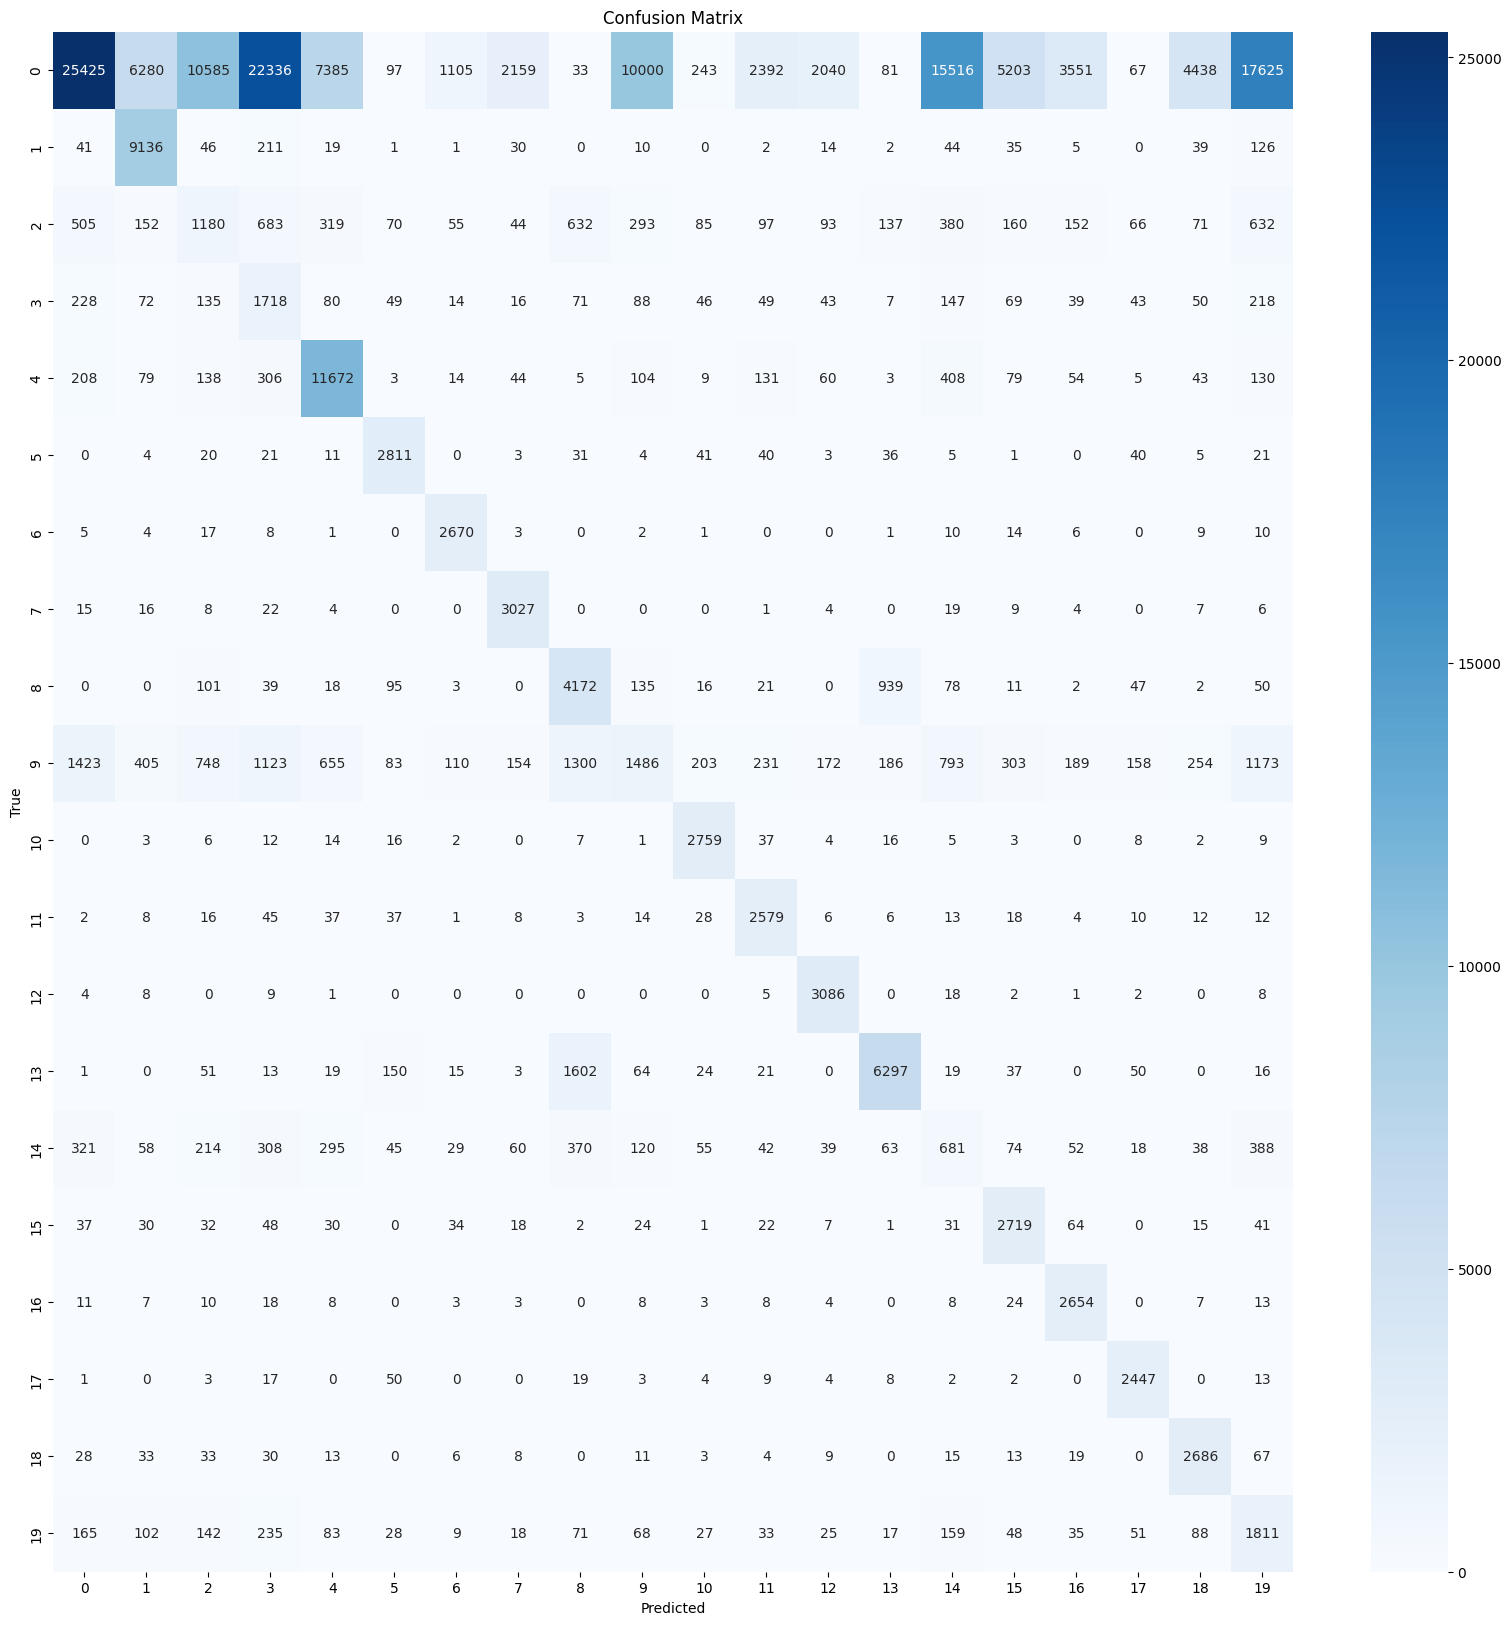

In [33]:
# @title Evaluating

# @markdown Now that our model has been trained, we can evaluate its performance on the testing set. We used the following classification metrics for evaluation:
# @markdown - *Confusion matrix*, described with this table.
# @markdown   <img src="https://images.datacamp.com/image/upload/v1701364260/image_5baaeac4c0.png" alt="Confusion matrix scheme" width=400/>
# @markdown
# @markdown - *Precision*, described by the formula:
# @markdown   $$
# @markdown   precision = \frac{TP}{TP+FP}
# @markdown   $$
# @markdown
# @markdown - *Recall*, described by the formula:
# @markdown   $$
# @markdown   recall = \frac{TP}{TP+FN}
# @markdown   $$
# @markdown
# @markdown - *Accuracy*, described by the formula:
# @markdown   $$
# @markdown   accuracy = \frac{TP+TN}{TP+FP+TN+FN}
# @markdown   $$
# @markdown
# @markdown - *F1-score*, described by the formula:
# @markdown   $$
# @markdown   F1 Score = 2 \times \frac{precision \times recall}{precision + recall}
# @markdown   $$

y_pred_probs = dnn_model.predict(
  tf.convert_to_tensor(dnn_test_df.drop(columns='label').values, dtype=tf.float32)
)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(
    dnn_test_df['label'].values,
    y_pred
)

y_test = tf.convert_to_tensor(dnn_test_df['label'].values, dtype=tf.int32)


# Calculate accuracy, precision, recall, and f1-score
print(classification_report(y_test, y_pred))

# Display the confusion matrix
plt.figure(figsize=(20, 20), )
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') #, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Analysis

In this section, we discuss of the performance of our model and compare it to Federated Learning (FL).

The proposed DNN achieved an accuracy score of 40 %, on the testing set. Its confusion matrice also looks partly diagonal, meaning that the model didn't confused a lot of labels, except `0` . This label stands for the benign messages. It shows that attacks are quiet difficult to recognize, even for an AI trained on more than 250 000 messages.

The proposed DNN didn't achieve 50 % of accurency on the testing dataset, though the dataset was balanced and large enough. The principal reason of this low efficiency might be the number of epochs. Indeed, we only trained our model on 50 epochs because each one of them took a lot of time. We also could have made a more complex DNN but we couldn't compare it to those we used with FL.

Federated Learning reached better results in the last project, though training were longer. Indeed, FL needed 20 epochs per DNN and a local models fusion to make one learning step with the global model. Moreover, each DNN used in FL had much less data and less classes to predict. Because the task was easier, the performance was better. To really compare the centralized learning and FL, we should have us the same dataset.

## Conclusion

In this project, we implemented a DNN to recognize and classify attacks in a connected vehicular network. Our proposed model reached 40 % of accuracy with only 50 epochs, though it could have been trained longer.

To improve our project, we can compare our model with one trained on Federated Learning, using the same dataset.